In [311]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
# !pip install --upgrade bson
# pip install git+https://github.com/hyperopt/hyperopt-sklearn.git

In [313]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import matplotlib.gridspec as gridspec
import scipy
from PIL import Image
from scipy.stats import binom
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV

from zoobot.active_learning import check_uncertainty, metrics, acquisition_utils

In [314]:
df = pd.read_parquet('decals_may_test_set_predictions.parquet')

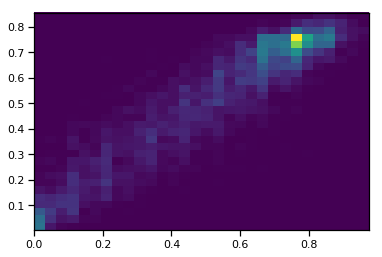

In [315]:
_ = plt.hist2d(df['smooth-or-featured_smooth_fraction'], df['median_prediction'], bins=[30, 30])

In [316]:
np.array(df['predictions'].values).shape

(5000,)

In [317]:
predictions = np.array(list(df['predictions'].values))

In [318]:
predictions[2]

array([0.69984019, 0.65375739, 0.67379183, 0.68753201, 0.66835594,
       0.68186891, 0.69126451, 0.67486584, 0.67951614, 0.66669625,
       0.71931338, 0.6611011 , 0.64438432, 0.71550411, 0.69574589,
       0.67577267, 0.69056255, 0.69870031, 0.70147198, 0.64727461,
       0.65751302, 0.70103586, 0.72273588, 0.68142498, 0.69571018,
       0.67701793, 0.66727364, 0.69075823, 0.64125341, 0.69616437])

In [319]:
pred_var = np.var(predictions, axis=1)

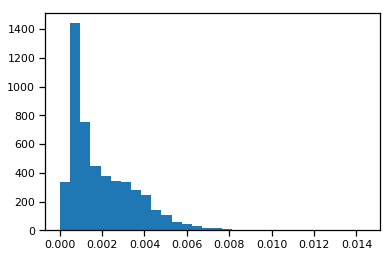

In [320]:
_ = plt.hist(pred_var, bins=30)

In [321]:
df['predictions_var'] = pred_var

In [322]:
def ml_likelihood(row):
    return binom.pmf(k=row['smooth-or-featured_smooth'], n=row['smooth-or-featured_total-votes'], p=row['median_prediction'])

In [323]:
df['bcnn_likelihood'] = df.apply(ml_likelihood, axis=1)

In [324]:
df['absolute_error'] = np.abs(df['median_prediction'] - df['smooth-or-featured_smooth'] / df['smooth-or-featured_total-votes'])

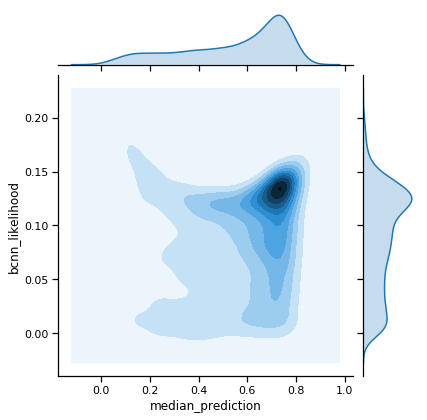

In [325]:
sns.jointplot(data=df.query('bcnn_likelihood < 0.2'), y='bcnn_likelihood', x='median_prediction', kind='kde')

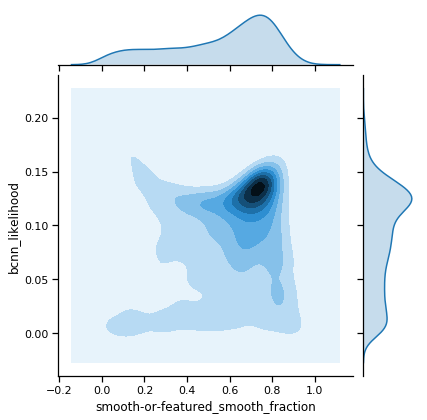

In [326]:
sns.jointplot(data=df.query('bcnn_likelihood < 0.2'), y='bcnn_likelihood', x='smooth-or-featured_smooth_fraction', kind='kde')

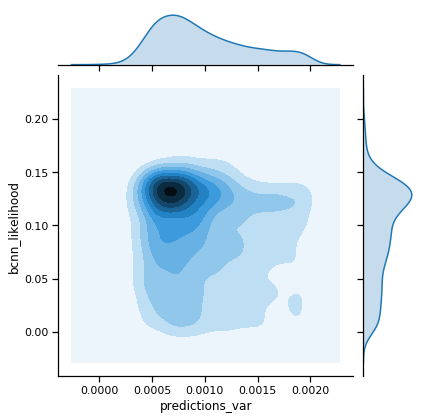

In [327]:
sns.jointplot(data=df.query('bcnn_likelihood < 0.2').query('predictions_var < 0.002'), y='bcnn_likelihood', x='predictions_var', kind='kde')

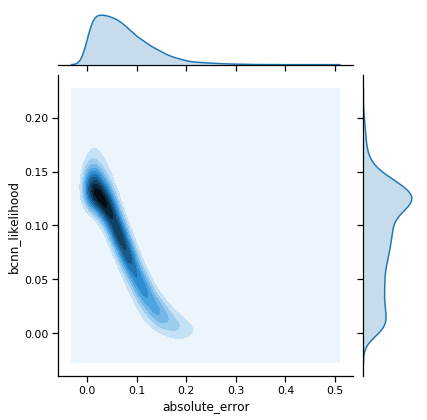

In [328]:
sns.jointplot(data=df.query('bcnn_likelihood < 0.2').query('predictions_var < 0.005'), y='bcnn_likelihood', x='absolute_error', kind='kde')

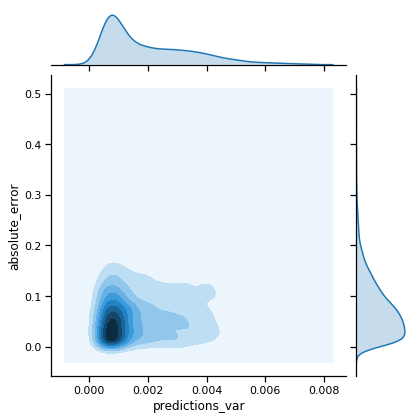

In [329]:
sns.jointplot(data=df.query('bcnn_likelihood < 0.2').query('predictions_var < 0.0075'), y='absolute_error', x='predictions_var', kind='kde')

In [330]:
# param_grid = {
#     'learning_rate': scipy.stats.uniform(loc=0.001, scale=0.02),
#     'n_estimators': scipy.stats.randint(low=50, high=1000),
#     'max_depth': scipy.stats.randint(low=2, high=5)
# }

In [331]:
# clf = GradientBoostingRegressor()

In [332]:

# https://scikit-learn.org/stable/modules/grid_search.html

# df['abs_error_gbm'] = cross_val_predict(clf, X=predictions, y=df['absolute_error'], cv=5)

In [333]:
# cv_search = RandomizedSearchCV(clf, param_grid, n_iter=40)
# X_cv, X_held, y_cv, y_held = train_test_split(predictions, df['bcnn_likelihood'])
# cv_search.fit(X=X_cv, y=y_cv)
# cv_search.best_params_

In [334]:
# gbm_cv_predictions = cv_search.predict(X_held)
# sns.jointplot(x=y_held, y=gbm_cv_predictions, kind='kde', ylim=[0., 0.2], xlim=[0., 0.2])

In [335]:
# sns.jointplot(x=df['absolute_error'], y=df['abs_error_gbm'], kind='kde')

In [336]:
clf = GradientBoostingRegressor()
df['likelihood_gbm'] = cross_val_predict(clf, X=predictions, y=df['bcnn_likelihood'], cv=5)

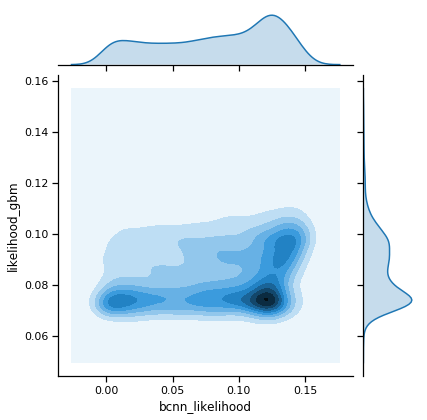

In [337]:
sns.jointplot(data=df.query('bcnn_likelihood < 0.15').query('likelihood_gbm < 0.15'), x='bcnn_likelihood', y='likelihood_gbm', kind='kde')

In [338]:
clf = GradientBoostingRegressor()
manual_features = np.stack([predictions.var(axis=1), predictions.mean(axis=1)], axis=1)
print(manual_features[0:3])
df['likelihood_manual_gbm'] = cross_val_predict(clf, X=manual_features, y=df['bcnn_likelihood'], cv=5)

[[5.65772258e-04 7.43358481e-01]
 [6.18014607e-04 7.14656913e-01]
 [4.43251179e-04 6.81940248e-01]]


(0.0, 0.01)

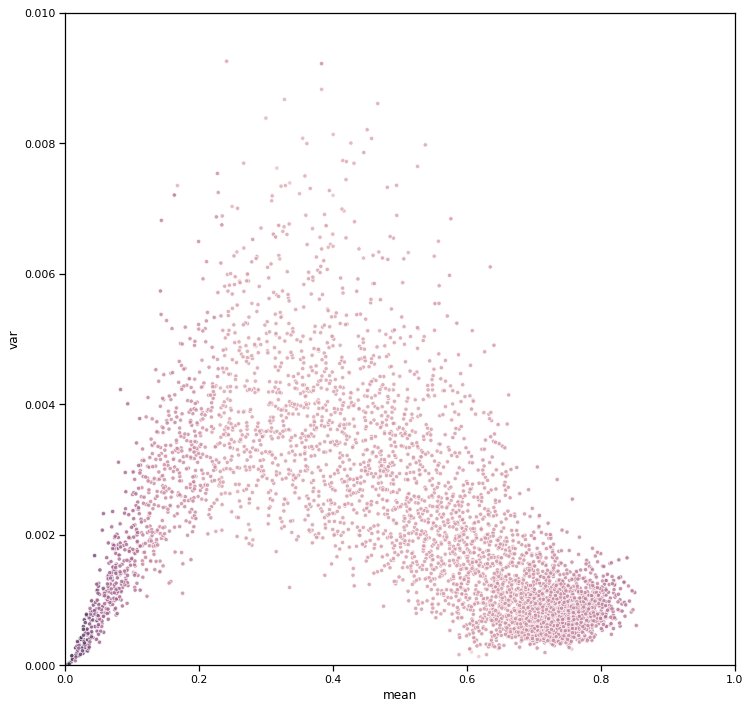

In [339]:
df['var'] = predictions.var(axis=1)
df['mean'] = predictions.mean(axis=1)
df['loglikelihood_manual_gbm'] = np.log(df['likelihood_manual_gbm'])
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df, x='mean', y='var', hue='loglikelihood_manual_gbm', size=.01, legend=False, ax=ax, alpha=0.8)
# sns.jointplot(data=df, x='var', y='mean', hue='likelihood_manual_gbm')
ax.set_xlim([0., 1.])
ax.set_ylim([0., .01])

(0.0, 0.01)

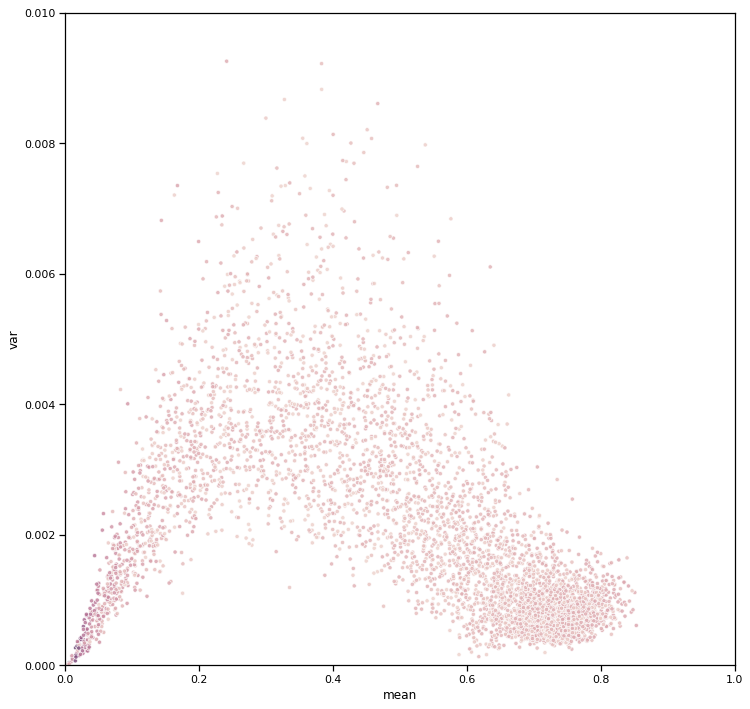

In [340]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df, x='mean', y='var', hue='bcnn_likelihood', size=.01, legend=False, ax=ax, alpha=0.8)
# sns.jointplot(data=df, x='var', y='mean', hue='likelihood_manual_gbm')
ax.set_xlim([0., 1.])
ax.set_ylim([0., .01])

In [341]:
def plot_2d_mean(x, y, values, nbins=(20, 20), nans=None):
    denominator, xedges, yedges = np.histogram2d(y, x, bins=nbins)
    nominator, _, _ = np.histogram2d(y, x, bins=[xedges, yedges], weights=values)
    result = nominator / denominator
    
    plt.imshow(result, origin='lower')
#     plt.xticks(xedges)
    plt.colorbar()
    return result

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


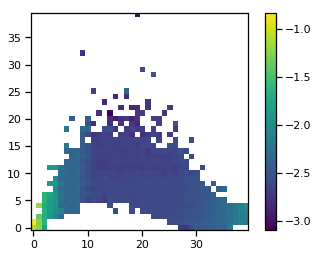

In [342]:
_ = plot_2d_mean(df['mean'], df['var'], df['loglikelihood_manual_gbm'], nbins=(40, 40))

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


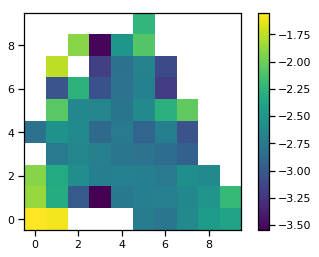

In [343]:
df_cut = df[np.log(df['bcnn_likelihood']) > -5]
_ = plot_2d_mean(df_cut['mean'], df_cut['var'], np.log(df_cut['bcnn_likelihood']), nbins=(10, 10))

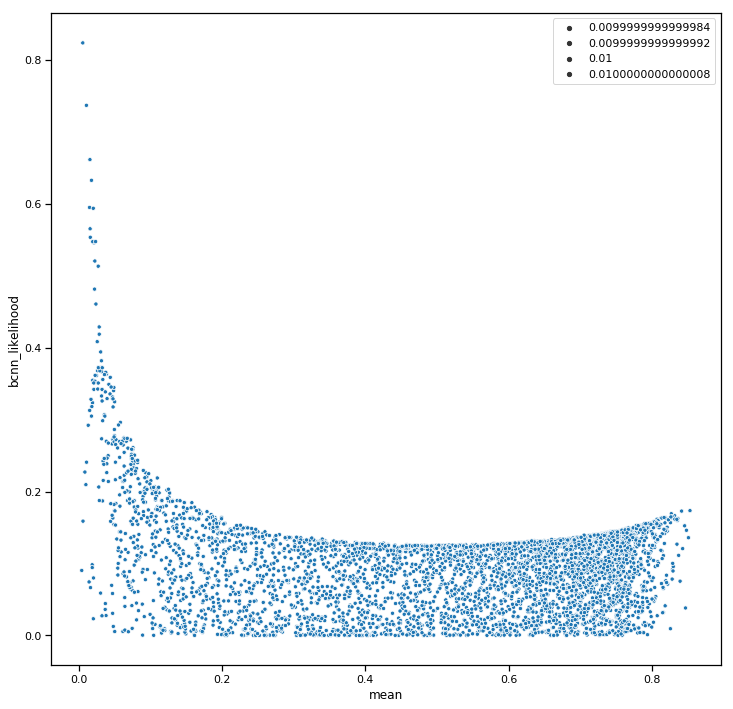

In [344]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df, x='mean', y='bcnn_likelihood', size=.01, ax=ax)

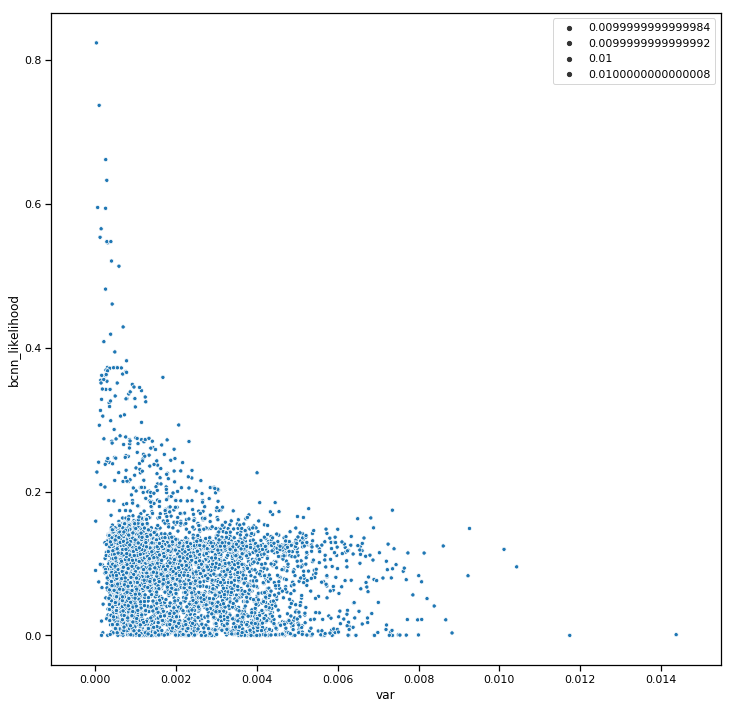

In [345]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df, x='var', y='bcnn_likelihood', size=.01, ax=ax)

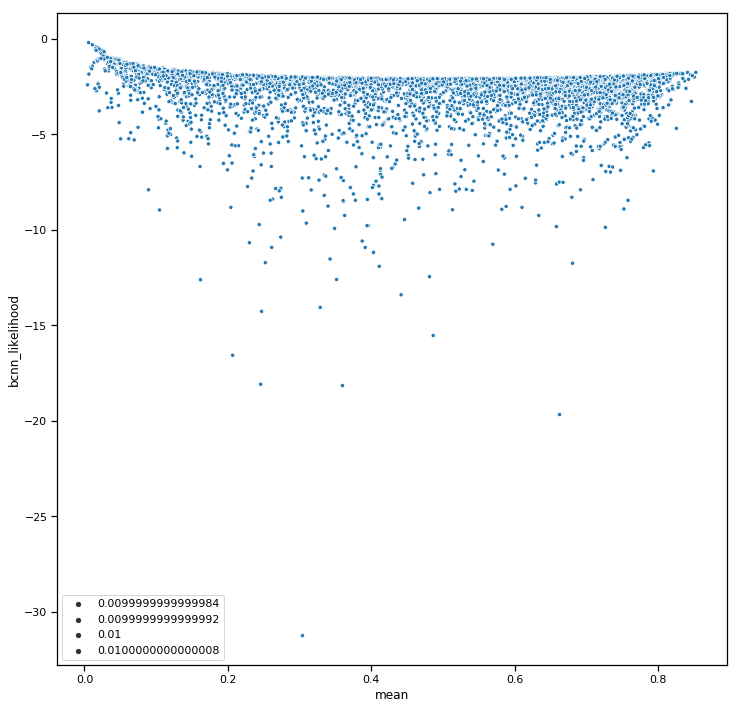

In [346]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=df, x='mean', y=np.log(df['bcnn_likelihood']), size=.01, ax=ax)

So mean and var are the only features the GBM needs, and they do okay but not fantastic. 
But, we know that model performance is really well predicted by the astro characteristics and mean votes. 
Let's combine!

In [347]:
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret import show
from astropy.table import Table

In [348]:
QUESTION = 'smooth'

In [349]:
# df = pd.read_parquet('/data/repos/zoobot/notebooks/{}_test_predictions_and_gz2_catalog.parquet'.format(QUESTION))
# df =pd.read_parquet('/data/repos/zoobot/notebooks/decals_may_test_set_predictions.parquet')


In [350]:
# gz2 catalog doesn't have nsa, let's merge that in for astro features
nsa_catalog_loc = '../data/nsa_v1_0_1.fits'
if not os.path.isfile(nsa_catalog_loc):
    !dvc pull -r s3 {nsa_catalog_loc}.dvc

In [351]:
physical_cols = ['MAG', 'Z', 'SERSIC_MASS', 'PETRO_BA50', 'PETRO_BA90', 'PETRO_THETA', ]

In [352]:
cols_to_load = ['RA', 'DEC'] + physical_cols
nsa_catalog = Table.read(nsa_catalog_loc)[cols_to_load]
for col in cols_to_load:
    nsa_catalog[col.lower()] = nsa_catalog[col]
    del nsa_catalog[col]
nsa_catalog = nsa_catalog.to_pandas()

In [353]:
from shared_astro_utils import matching_utils
import astropy.units as u

In [354]:
nsa_df, _ = matching_utils.match_galaxies_to_catalog_pandas(df, nsa_catalog, matching_radius=u.arcsec * 1000)

In [355]:
del nsa_catalog  # to conserve memory

In [356]:
limits = {
    'mag': [14., 18.],
    'z': None,
    'log_sersic_mass': [8.5, 11.2],
    'petro_ba50': [0.4, 1.],
    'petro_ba90': [0.4, 1.],
    'petro_theta': [2.5, 20.]
}

In [357]:
nsa_df['log_sersic_mass'] = np.log10(nsa_df['sersic_mass'])

In [363]:
safe_df = nsa_df.copy()
for col, lims in limits.items():
    if lims:
        print(col, lims)
        safe_df = safe_df.query('{} > {}'.format(col, lims[0])).query('{} < {}'.format(col, lims[1]))
        print(len(safe_df))

mag [14.0, 18.0]
3433
log_sersic_mass [8.5, 11.2]
3311
petro_ba50 [0.4, 1.0]
3298
petro_ba90 [0.4, 1.0]
3142
petro_theta [2.5, 20.0]
3067


In [364]:
relevant_gz_cols =  ['t03_bar_a06_bar_fraction', 't01_smooth_or_features_a02_features_or_disk_fraction', 't04_spiral_a08_spiral_fraction']
relevant_physical_cols = ['mag', 'z', 'log_sersic_mass', 'petro_ba50', 'petro_ba90', 'petro_theta']

In [365]:
len(safe_df)

3067

In [366]:
seed = 1
# feature_cols = relevant_physical_cols + relevant_gz_cols
feature_cols = relevant_physical_cols + ['mean', 'var']
safe_df = safe_df.dropna(subset=feature_cols)
# y = safe_df['bcnn_likelihood'].values
# X = safe_df[[col.lower() for col in feature_cols]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [367]:
# ebm = ExplainableBoostingRegressor(random_state=seed)
# ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(data_n_episodes=2000, early_stopping_run_length=50,
                             early_stopping_tolerance=1e-05,
                             feature_names=['mag', 'z', 'log_sersic_mass',
                                            'petro_ba50', 'petro_ba90',
                                            'petro_theta', 'mean', 'var'],
                             feature_step_n_inner_bags=0,
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous'],
                             holdout_size=0.15, holdout_split=0.15,
                             interactions=0, learning_rate=0.01,
                             max_tree_splits=2, min_cases_for_splits=2,
                             n_estimators=16, n_jobs=-2, random_state=1,
           

In [374]:
clf = GradientBoostingRegressor()
safe_df['likelihood_physical'] = cross_val_predict(clf, X=safe_df[feature_cols], y=safe_df['bcnn_likelihood'], cv=5)

In [ ]:
# plt.hist(np.log(df['likelihood_manual_gbm']))

In [ ]:
# !pip install lime

In [ ]:


# import lime
# import lime.lime_tabular

# explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names, class_names=['price'], categorical_features=categorical_features, verbose=True, mode='regression')


In [ ]:
sns.jointplot(data=df.query('bcnn_likelihood < 0.15').query('likelihood_manual_gbm < 0.15'), x='bcnn_likelihood', y='likelihood_manual_gbm', kind='kde')

In [ ]:
df['random'] = np.random.rand(len(df))

In [ ]:
def experiment(df, score_col, min_galaxies=100):  # containing bcnn_likelihood and score_col
    df = df.sort_values(score_col, ascending=False)
    galaxies_removed = 0
    total_galaxies = len(df) - min_galaxies
    mean_likelihood = np.zeros(total_galaxies)
    removed_mean_likelihood = np.zeros(total_galaxies)
    each_removed = np.zeros(total_galaxies)
    for n in range(total_galaxies):
        mean_likelihood[n] = df[n:]['bcnn_likelihood'].mean()
        removed_mean_likelihood[n] = df[:n]['bcnn_likelihood'].mean()
        if n == 0:
            each_removed[n] = np.nan
        else:
            each_removed[n] = df.iloc[n]['bcnn_likelihood']
    return mean_likelihood, removed_mean_likelihood, each_removed

In [ ]:
df['neg_predictions_var'] = - df['predictions_var']

In [ ]:
mean_likelhood_with_likelihood, removed_with_likelihood, er_likelihood = experiment(df, 'likelihood_gbm')

In [ ]:
# mean_likelhood_with_abs_error, removed_with_error, er_likelihood = experiment(df, 'abs_error_gbm')

In [ ]:
mean_likelhood_with_random, removed_with_random, er_random = experiment(df, 'random')

In [ ]:
mean_likelhood_with_var, removed_with_var, er_var = experiment(df, 'neg_predictions_var')

In [ ]:
mean_likelhood_with_manual_gbm, removed_with_manual_gbm, er_manual_gbm = experiment(df, 'likelihood_manual_gbm')

In [375]:
mean_likelhood_with_physical, removed_with_physical, er_with_physical = experiment(safe_df, 'likelihood_physical')

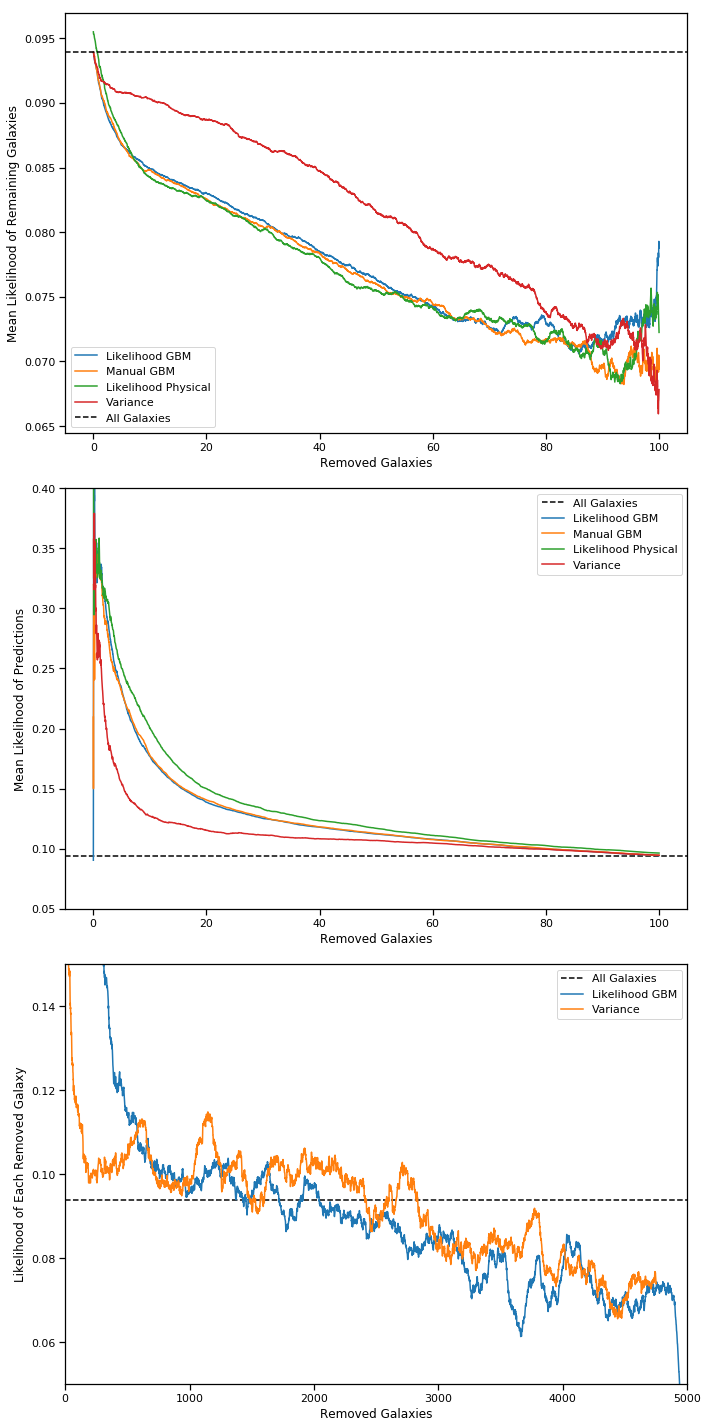

In [390]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 20))

ax = axes[0]
# ax.plot(mean_likelhood_with_abs_error, label='abs_8error_gbm')
x_standard = np.linspace(0., 100., len(mean_likelhood_with_likelihood))
x_safe = np.linspace(0., 100., len(mean_likelhood_with_physical))
ax.plot(x_standard, mean_likelhood_with_likelihood, label='Likelihood GBM')
ax.plot(x_standard, mean_likelhood_with_manual_gbm, label='Manual GBM')
ax.plot(x_safe, mean_likelhood_with_physical, label='Likelihood Physical')
ax.plot(x_standard, mean_likelhood_with_var, label='Variance')
# ax.plot(mean_likelhood_with_random, label='Random')
ax.axhline(df['bcnn_likelihood'].mean(), color='k', linestyle='--', label='All Galaxies')
ax.set_ylabel('Mean Likelihood of Remaining Galaxies')
ax.set_xlabel('Removed Galaxies')
# ax.set_xlim([0, 5000])
ax.legend(loc=3)


ax = axes[1]
ax.axhline(df['bcnn_likelihood'].mean(), color='k', linestyle='--', label='All Galaxies')
# ax.plot(removed_with_error, label='abs_error_gbm')
ax.plot(x_standard, removed_with_likelihood, label='Likelihood GBM')
ax.plot(x_standard, removed_with_manual_gbm, label='Manual GBM')
ax.plot(x_safe, removed_with_physical, label='Likelihood Physical')
removed_with_var[:3] = np.nan
ax.plot(x_standard, removed_with_var, label='Variance')
# ax.plot(removed_with_random, label='Random')
ax.set_xlabel('Removed Galaxies')
ax.set_ylabel('Mean Likelihood of Predictions')
ax.set_ylim([0.05, 0.4])
# ax.set_ylim([0.08, 0.2])
# ax.set_xlim([0, 5000])
ax.legend(loc=1)

N = 150
ax = axes[2]
ax.axhline(df['bcnn_likelihood'].mean(), color='k', linestyle='--', label='All Galaxies')
# ax.plot(removed_with_error, label='abs_error_gbm')
ax.plot(np.convolve(er_likelihood, np.ones((N,))/N, mode='full'), label='Likelihood GBM')
ax.plot(np.convolve(er_var, np.ones((N,))/N, mode='valid'), label='Variance')
# ax.plot(np.convolve(er_random, np.ones((N,))/N, mode='valid'), label='Random')
ax.set_xlabel('Removed Galaxies')
ax.set_ylabel('Likelihood of Each Removed Galaxy')
ax.set_ylim([0.05, 0.15])
ax.set_xlim([0, 5000])
ax.legend(loc=1)

fig.tight_layout()
# fig.savefig()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(df['bcnn_likelihood'].mean(), color='k', linestyle='--', label='All Galaxies')
# ax.plot(removed_with_error, label='abs_error_gbm')
ax.plot(removed_with_likelihood, label='Likelihood GBM')
removed_with_var[:3] = np.nan
ax.plot(removed_with_var, label='Variance')
# ax.plot(removed_with_random, label='Random')
ax.set_xlabel('ML-Classified Galaxies')
ax.set_ylabel('Mean Likelihood of Predictions')
ax.set_ylim([0.08, 0.2])
ax.set_xlim([0, 5000])
ax.legend(loc=1)
fig.tight_layout()


### Make random responses to see what the GBM is looking for - why should it outperform variance?

In [ ]:
clf_nocv = GradientBoostingRegressor().fit(predictions, y=df['bcnn_likelihood'])  # previously used cv_predict, so not actually fit

In [ ]:
fake_predictions = np.random.rand(100000, 30)
expected_likelihoods = clf_nocv.predict(fake_predictions)

In [ ]:
plt.hist(expected_likelihoods, bins=40)

In [ ]:
_ = plot_2d_mean(fake_predictions.mean(axis=1), fake_predictions.var(axis=1), expected_likelihoods)

In [ ]:
clf_nocv_manual = GradientBoostingRegressor().fit(X=df[['mean', 'var']], y=df['bcnn_likelihood'])  # previously used cv_predict, so not actually fit
fake_vars = np.linspace(0., 20., 1000)
fake_means = np.linspace(0., 15., 1000)
x, y = np.meshgrid(fake_means, fake_vars)


In [ ]:
x  # 0...15, 0..15, ...

In [ ]:
y  £ 0...20, 0...20

In [ ]:
examples = np.array(list(zip(x.flatten(), y.flatten())))

In [ ]:
examples

In [ ]:
examples.shape

In [ ]:
manual_expected_l = clf_nocv_manual.predict(examples)

In [ ]:
examples.min(), examples.max()

In [ ]:
result = plot_2d_mean(examples[:, 0], examples[:, 1], np.log(manual_expected_l))

In [ ]:
expected_worst = fake_predictions[np.argmin(expected_likelihoods)]
sns.rugplot(expected_worst)
expected_worst.var(), expected_worst.mean()

In [ ]:
expected_best = fake_predictions[np.argmax(expected_likelihoods)]
sns.rugplot(expected_best)
expected_best.var(), expected_best.mean()

In [ ]:
from scipy.optimize import minimize

In [ ]:
clf_nocv.predict(expected_worst.reshape(1, -1))

In [ ]:
# x0 = expected_worst


In [ ]:
def get_high_likelihood():
    x0 = np.random.rand(30)
    bounds = [(0, 1) for _ in range(len(x0))]
    result = minimize(lambda x: -clf_nocv.predict(x.reshape(1, -1)), x0=x0, bounds=bounds)
    return result.x

def get_low_likelihood():
    x0 = np.random.rand(30)
    bounds = [(0, 1) for _ in range(len(x0))]
    result = minimize(lambda x: clf_nocv.predict(x.reshape(1, -1)), x0=x0, bounds=bounds)
    return result.x

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 8))
for row_n, row in enumerate(axes):
    row[0].scatter(get_high_likelihood(), [row_n] * 30)
    row[1].scatter(get_low_likelihood(), [row_n] * 30)
        

In [ ]:
sorted_predictions = fake_predictions[np.argsort(expected_likelihoods)]

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 8))
for row_n, row in enumerate(axes):
    
    row[0].scatter(sorted_predictions[row_n], [row_n] * 30, label=sorted_predictions[row_n].var())
    row[1].scatter(sorted_predictions[-row_n-1], [row_n] * 30, label=sorted_predictions[-row_n-1].var())
    row[0].set_xlim([0., 1])
    row[1].set_xlim([0., 1])
    row[0].legend()
    row[1].legend()
        

In [ ]:
plt.hist2d(fake_predictions.var(axis=1), expected_likelihoods)
plt.figure()
_ = plt.hist2d(fake_predictions.mean(axis=1), expected_likelihoods)

In [ ]:
# np.sort(expected_likelihoods)  
expected_likelihoods[np.argsort(expected_likelihoods)]

In [ ]:
sorted_predictions = fake_predictions[np.argsort(expected_likelihoods)]  # sorted from low likelihood (bad) to high likelihood (good)
best = sorted_predictions[-5000:]  # highest likelihoods
worst = sorted_predictions[:5000]  # lowest likelihoods
bins=20

plt.hist(best.var(axis=1), alpha=0.5, label='best', bins=bins)
plt.hist(worst.var(axis=1), alpha=0.5, label='worst', bins=bins)
plt.legend()

plt.figure()
plt.hist(best.mean(axis=1), alpha=0.5, label='best', bins=bins)
plt.hist(worst.mean(axis=1), alpha=0.5, label='worst', bins=bins)
plt.legend()

# plt.figure()
# plt.hist(best.median(axis=1), alpha=0.5, label='best')
# plt.hist(worst.median(axis=1), alpha=0.5, label='worst')
# plt.legend()

In [ ]:
plt.scatter(range(len(result.x)), result.x)

In [ ]:
_ = plot_acf(result.x)

In [ ]:
plt.plot(autocorr(result.x))

In [ ]:
x0 = np.random.rand(30)
bounds = [(0, 1) for _ in range(len(x0))]

result = minimize(lambda x: -clf_nocv.predict(x.reshape(1, -1)), x0=x0, bounds=bounds)
print(result)
sns.rugplot(result.x)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
_ = plot_acf(result.x)

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [ ]:
plt.plot(autocorr(result.x))

In [ ]:
plt.plot(autocorr(expected_best))
plt.plot(autocorr(expected_worst))

### Let's visualise which galaxies it expects to be best and worst, and the actual scores

In [ ]:
df['file_loc'] = df['id_str'].apply(lambda x: 'decals_smooth_may_eval_shards/test_images/{}.png'.format(x))

In [ ]:
df.iloc[0]

In [ ]:
df.columns.values

In [ ]:
df.to_csv('decals_smooth_may_eval_shards/mac_catalog.csv', index=False)

In [ ]:
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
    print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


In [ ]:
_ = show_galaxies(df.sort_values('random', ascending=False))

In [ ]:
_ = show_galaxies(df.sort_values('predictions_var', ascending=True)[50:])

In [ ]:
fig = show_galaxies(df.sort_values('predictions_var', ascending=False)[20:])

In [ ]:
fig.savefig('bristol_least_confident_rho.')

### With GBM:

In [ ]:
show_galaxies(df.sort_values('likelihood_gbm', ascending=False))

In [ ]:
show_galaxies(df.sort_values('likelihood_gbm', ascending=True))

### Where the humans are unsure, it's harder to predict what the humans will say

In [ ]:
def show_score_bins(df, score_col, n_bins=10, n_galaxies_per_bin=10):
    df['binned_score'], bins = pd.qcut(df[score_col], n_bins, labels=False, retbins=True)
    scale = 3
    plt.figure(figsize=(scale * n_galaxies_per_bin, scale * n_bins))
    gs1 = gridspec.GridSpec(n_galaxies_per_bin, n_bins)
    gs1.update(wspace=0.0, hspace=0.0)
    for bin_n in range(n_bins):
        selected_df = df.query('binned_score == {}'.format(bin_n))
        for galaxy_n in range(n_galaxies_per_bin):
            if galaxy_n < len(selected_df):
                galaxy = selected_df.iloc[galaxy_n]
                image = Image.open(galaxy['file_loc'])
                ax = plt.subplot(gs1[galaxy_n, bin_n])
                ax.imshow(image)
#                 ax.text(50, 50, 'Feat = {:.2f}'.format(galaxy['featured_fraction']), fontsize=16, color='r')
#                 ax.text(50, 120, 'N = {}'.format(galaxy['total']), fontsize=16, color='r')
                if galaxy_n == 0:
                    ax.text(50, -50, 'S: {:.4f} to {:.4f}'.format(bins[bin_n], bins[bin_n + 1]), fontsize=16, color='black')
                ax.axis('off')
#     plt.savefig('touch_table_retirement_{}.pdf'.format(retirement_limit))
    return df

In [ ]:
_ = show_score_bins(df.sample(len(df)), 'neg_predictions_var')

In [ ]:
_ = show_score_bins(df.sample(len(df)), 'likelihood_gbm')

In general, I would say the most confident 50% are indeed pretty easy for humans and the least confident 50% are a mix of easy and difficult (for me)